In [9]:
try:
    import os
    import glob
    import pandas as pd

    import matplotlib.pyplot as plt
    import seaborn as sns

    from sklearn.cluster import KMeans
    from kneed import KneeLocator

except Exception as e:
    print(f"Error : {e}")

In [10]:
# Find the CSV file in the Datasets directory
data_path = '../Datasets/*.csv'
file_list = glob.glob(data_path)

for file in file_list:
    print(f"Found file: {file}")

# Ensure there is exactly one file
if len(file_list) == 1:
    # Load the dataset
    df = pd.read_csv(file_list[0])
    print(f"Loaded dataset: {file_list[0]}")
else:
    raise FileNotFoundError("No CSV file found or multiple CSV files found in the Datasets directory.")

Found file: ../Datasets/Dataset.csv
Loaded dataset: ../Datasets/Dataset.csv


In [11]:
# File path to save the trained model
destination = '../Models/'
os.makedirs(destination, exist_ok=True)
print(f"Model will be saved to: {destination}")

Model will be saved to: ../Models/


In [12]:
clf_df = df.copy()

clf_df['1500_labels'] = clf_df['Lifespan'].apply(lambda x: 1 if x >= 1500 else 0)

clf_df.head()

,Lifespan,partType,microstructure,coolingRate,quenchTime,forgeTime,HeatTreatTime,Nickel%,Iron%,Cobalt%,Chromium%,smallDefects,largeDefects,sliverDefects,seedLocation,castType,1500_labels
0,1469.17,Nozzle,equiGrain,13,3.84,6.47,46.87,65.73,16.52,16.82,0.93,10,0,0,Bottom,Die,0
1,1793.64,Block,singleGrain,19,2.62,3.48,44.70,54.22,35.38,6.14,4.26,19,0,0,Bottom,Investment,1
2,700.60,Blade,equiGrain,28,0.76,1.34,9.54,51.83,35.95,8.81,3.41,35,3,0,Bottom,Investment,0
3,1082.10,Nozzle,colGrain,9,2.01,2.19,20.29,57.03,23.33,16.86,2.78,0,1,0,Top,Continuous,0
4,1838.83,Blade,colGrain,16,4.13,3.87,16.13,59.62,27.37,11.45,1.56,10,0,0,Top,Die,1


In [13]:
min_lifespan = clf_df['Lifespan'].min()
max_lifespan = clf_df['Lifespan'].max()

print(f"Minimum Lifespan: {min_lifespan}")
print(f"Maximum Lifespan: {max_lifespan}")

Minimum Lifespan: 417.99
Maximum Lifespan: 2134.53


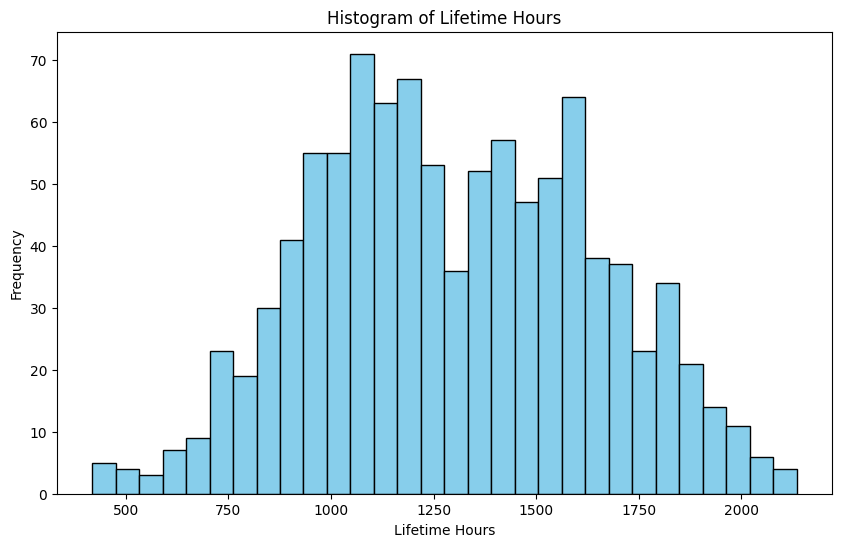

In [14]:
# Histogram to understand the distribution of 'lifetime_hours'
plt.figure(figsize=(10, 6))
plt.hist(clf_df['Lifespan'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Lifetime Hours')
plt.ylabel('Frequency')
plt.title('Histogram of Lifetime Hours')
plt.show()

In [15]:
# Selecting only 'Lifespan' for simplicity
X = clf_df[['Lifespan']]

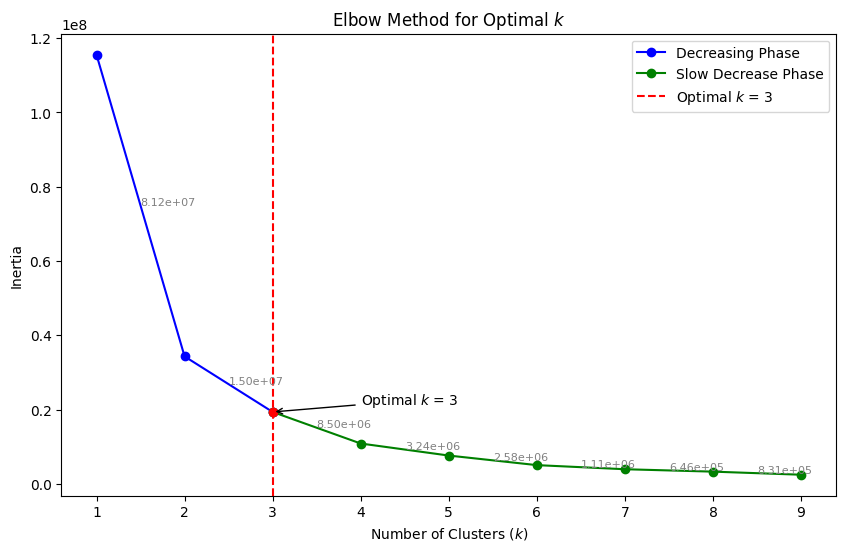

In [16]:
# Initialize a list to store inertia values
inertia = []
k_values = range(1, 10)

# Calculate inertia for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Dynamically determine the elbow point using KneeLocator
kneedle = KneeLocator(k_values, inertia, curve='convex', direction='decreasing')
elbow_k = kneedle.elbow

# Plotting the Elbow Method with all indicators
plt.figure(figsize=(10, 6))
# Plot line segments with different colors
plt.plot(k_values[:elbow_k], inertia[:elbow_k], 'bo-', label="Decreasing Phase")
plt.plot(k_values[elbow_k - 1:], inertia[elbow_k - 1:], 'go-', label="Slow Decrease Phase")

# Vertical line at elbow
plt.axvline(x=elbow_k, linestyle='--', color='r', label=f'Optimal $k$ = {elbow_k}')

# Highlight the elbow point with a red marker and annotation
plt.plot(elbow_k, inertia[elbow_k - 1], 'ro')  # red point at elbow
plt.annotate(f"Optimal $k$ = {elbow_k}", xy=(elbow_k, inertia[elbow_k - 1]),
             xytext=(elbow_k + 1, inertia[elbow_k - 1] + 0.2e7),
             arrowprops=dict(facecolor='black', arrowstyle="->"))

# Annotate each segment with inertia differences
for i in range(1, len(k_values)):
    plt.annotate(f"{inertia[i-1] - inertia[i]:.2e}",
                 (k_values[i] - 0.5, (inertia[i-1] + inertia[i]) / 2),
                 fontsize=8, color='gray')

# Set plot labels and title
plt.xlabel(f'Number of Clusters ($k$)')
plt.ylabel('Inertia')
plt.title(f'Elbow Method for Optimal $k$')
plt.legend()
plt.show()

In [17]:
kmeans = KMeans(n_clusters=elbow_k, random_state=42)
clf_df['cluster_group'] = kmeans.fit_predict(X)

In [18]:
# Group the data by 'cluster_group' and aggregate to find the min and max Lifespan for each cluster
cluster_ranges = clf_df.groupby('cluster_group')['Lifespan'].agg(['min', 'max']).reset_index()

# Display the value ranges for each cluster
print(cluster_ranges)

   cluster_group      min      max
0              0  1483.73  2134.53
1              1  1085.23  1480.43
2              2   417.99  1085.01


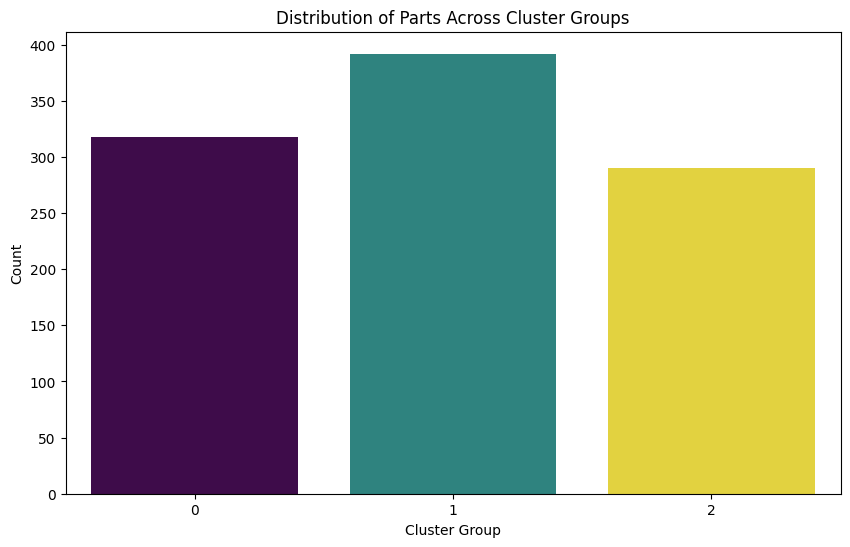

In [19]:
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster_group', data=clf_df, hue='cluster_group', palette='viridis', legend=False)
plt.xlabel('Cluster Group')
plt.ylabel('Count')
plt.title('Distribution of Parts Across Cluster Groups')
plt.show()

In [20]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(X, kmeans.labels_)
print(f'Silhouette Score for k={elbow_k}: {silhouette_avg:.2f}')

Silhouette Score for k=3: 0.52


Loaded dataset: ../Datasets/Dataset.csv
Minimum Lifespan: 417.99
Maximum Lifespan: 2134.53


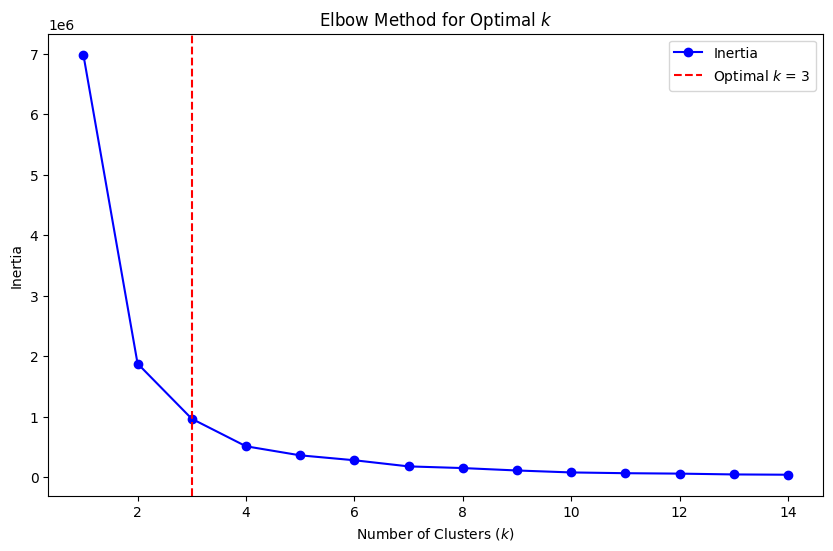

   cluster_group      min      max
0              0  1501.76  1661.54
1              1  1854.50  2134.53
2              2  1666.64  1850.75
Silhouette Score for k=3: 0.58


/var/folders/pb/_45838w13ds5fcrv51k520zh0000gn/T/ipykernel_51763/4240035983.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  above_threshold['cluster_group'] = kmeans.fit_predict(X)
/var/folders/pb/_45838w13ds5fcrv51k520zh0000gn/T/ipykernel_51763/4240035983.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  above_threshold['clusterCategory'] = above_threshold['cluster_group'].map(cluster_mapping)
/var/folders/pb/_45838w13ds5fcrv51k520zh0000gn/T/ipykernel_51763/4240035983.py:75: FutureWarning: A value 

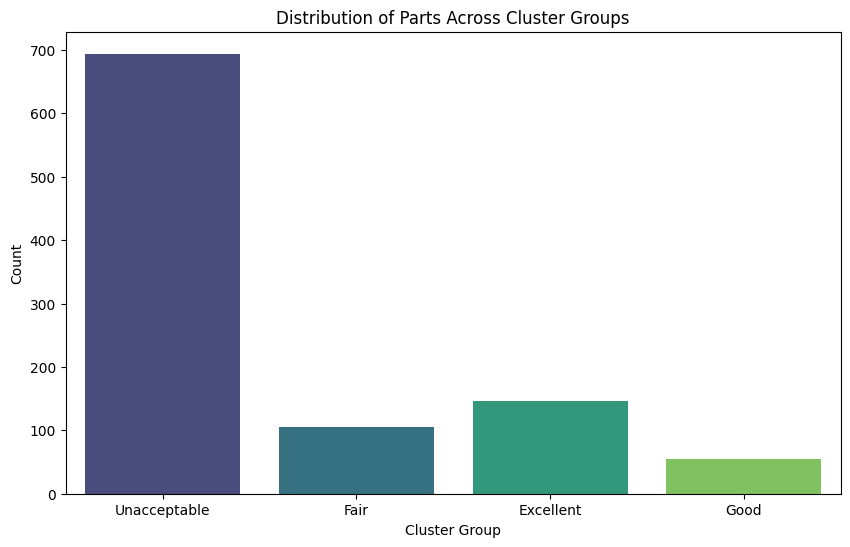

,Lifespan,partType,microstructure,coolingRate,quenchTime,forgeTime,HeatTreatTime,Nickel%,Iron%,Cobalt%,Chromium%,smallDefects,largeDefects,sliverDefects,seedLocation,castType,clusterCategory
0,1469.17,Nozzle,equiGrain,13,3.84,6.47,46.87,65.73,16.52,16.82,0.93,10,0,0,Bottom,Die,Unacceptable
1,1793.64,Block,singleGrain,19,2.62,3.48,44.70,54.22,35.38,6.14,4.26,19,0,0,Bottom,Investment,Fair
2,700.60,Blade,equiGrain,28,0.76,1.34,9.54,51.83,35.95,8.81,3.41,35,3,0,Bottom,Investment,Unacceptable
3,1082.10,Nozzle,colGrain,9,2.01,2.19,20.29,57.03,23.33,16.86,2.78,0,1,0,Top,Continuous,Unacceptable
4,1838.83,Blade,colGrain,16,4.13,3.87,16.13,59.62,27.37,11.45,1.56,10,0,0,Top,Die,Fair


In [21]:
# Import necessary libraries
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score

# File Path Configuration
data_path = '../Datasets/*.csv'
destination = '../Models/'
os.makedirs(destination, exist_ok=True)

# Load the dataset
file_list = glob.glob(data_path)
if len(file_list) == 1:
    df = pd.read_csv(file_list[0])
    print(f"Loaded dataset: {file_list[0]}")
else:
    raise FileNotFoundError("No CSV file found or multiple CSV files found in the Datasets directory.")

# Create a copy of the dataset and add the 1500 labels
clf_df = df.copy()
threshold_value = 1500

# Data exploration
print(f"Minimum Lifespan: {clf_df['Lifespan'].min()}")
print(f"Maximum Lifespan: {clf_df['Lifespan'].max()}")

# Clustering approach for lifespan above 1500 hours
# Selecting only records greater than threshold_value for clustering
above_threshold = clf_df[clf_df['Lifespan'] > threshold_value]
X = above_threshold[['Lifespan']]

# Determine the optimal number of clusters using the Elbow Method
inertia = []
k_values = range(1, 15)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Dynamically determine the elbow point using KneeLocator
kneedle = KneeLocator(k_values, inertia, curve='convex', direction='decreasing')
elbow_k = kneedle.elbow

# Plotting the Elbow Method with all indicators
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, 'bo-', label="Inertia")
plt.axvline(x=elbow_k, linestyle='--', color='r', label=f'Optimal $k$ = {elbow_k}')
plt.xlabel(f'Number of Clusters ($k$)')
plt.ylabel('Inertia')
plt.title(f'Elbow Method for Optimal $k$')
plt.legend()
plt.show()

# Fit KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=elbow_k, random_state=42)
above_threshold['cluster_group'] = kmeans.fit_predict(X)

# Group the data by 'cluster_group' and aggregate to find the min and max Lifespan for each cluster
cluster_ranges = above_threshold.groupby('cluster_group')['Lifespan'].agg(['min', 'max']).reset_index()
print(cluster_ranges)

# Calculate the silhouette score to evaluate clustering
silhouette_avg = silhouette_score(X, kmeans.labels_)
print(f'Silhouette Score for k={elbow_k}: {silhouette_avg:.2f}')

# Update labels in the original dataset
cluster_mapping = {0: 'Excellent', 1: 'Good', 2: 'Fair', 3: 'Low'}  # Update mapping accordingly
above_threshold['clusterCategory'] = above_threshold['cluster_group'].map(cluster_mapping)
clf_df = clf_df.merge(above_threshold[['Lifespan', 'clusterCategory']], on='Lifespan', how='left')
clf_df['clusterCategory'].fillna('Unacceptable', inplace=True)

# Visualization of clustering results
plt.figure(figsize=(10, 6))
sns.countplot(x='clusterCategory', data=clf_df, palette='viridis')
plt.xlabel('Cluster Group')
plt.ylabel('Count')
plt.title('Distribution of Parts Across Cluster Groups')
plt.show()

# Final output
clf_df.head()

Loaded dataset: ../Datasets/Dataset.csv
Minimum Lifespan: 417.99
Maximum Lifespan: 2134.53


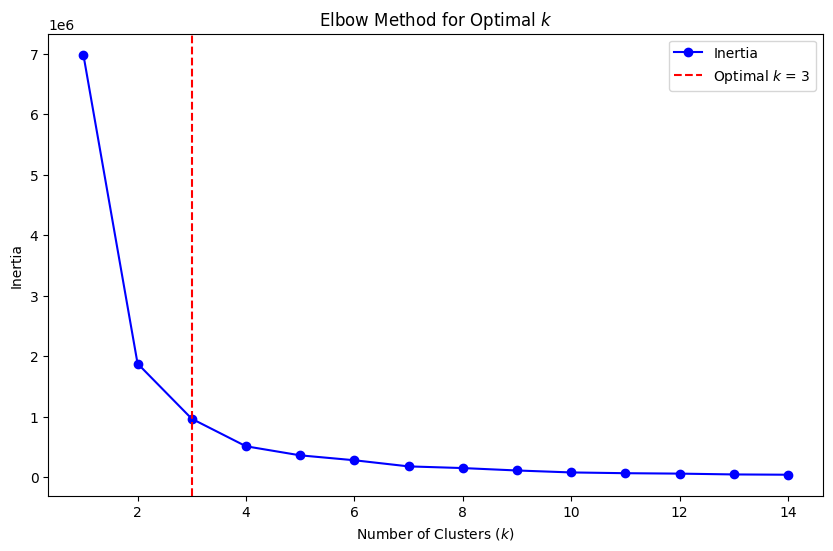

   cluster_group      min      max
0              0  1501.76  1661.54
1              1  1854.50  2134.53
2              2  1666.64  1850.75
Silhouette Score for k=3: 0.58


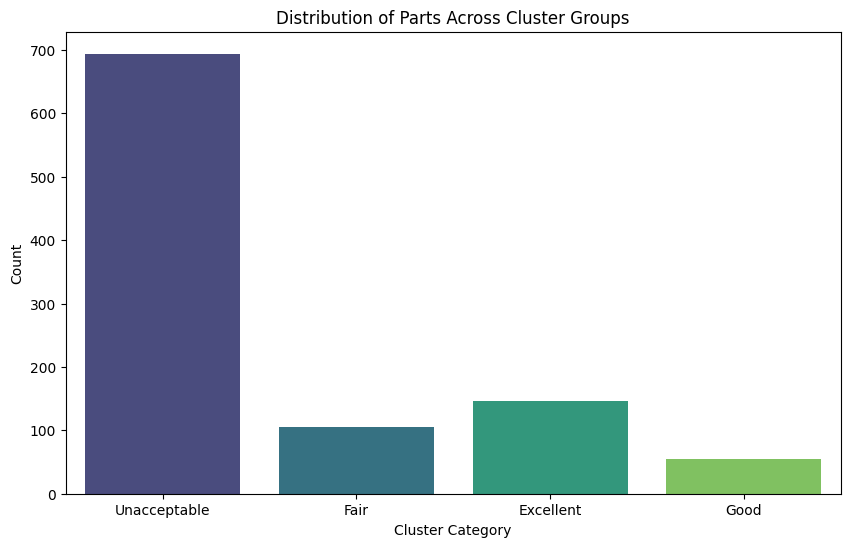

,Lifespan,partType,microstructure,coolingRate,quenchTime,forgeTime,HeatTreatTime,Nickel%,Iron%,Cobalt%,Chromium%,smallDefects,largeDefects,sliverDefects,seedLocation,castType,clusterCategory
0,1469.17,Nozzle,equiGrain,13,3.84,6.47,46.87,65.73,16.52,16.82,0.93,10,0,0,Bottom,Die,Unacceptable
1,1793.64,Block,singleGrain,19,2.62,3.48,44.70,54.22,35.38,6.14,4.26,19,0,0,Bottom,Investment,Fair
2,700.60,Blade,equiGrain,28,0.76,1.34,9.54,51.83,35.95,8.81,3.41,35,3,0,Bottom,Investment,Unacceptable
3,1082.10,Nozzle,colGrain,9,2.01,2.19,20.29,57.03,23.33,16.86,2.78,0,1,0,Top,Continuous,Unacceptable
4,1838.83,Blade,colGrain,16,4.13,3.87,16.13,59.62,27.37,11.45,1.56,10,0,0,Top,Die,Fair


In [22]:
# Import necessary libraries
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score

# File Path Configuration
data_path = '../Datasets/*.csv'
destination = '../Models/'
os.makedirs(destination, exist_ok=True)

# Load the dataset
file_list = glob.glob(data_path)
if len(file_list) == 1:
    df = pd.read_csv(file_list[0])
    print(f"Loaded dataset: {file_list[0]}")
else:
    raise FileNotFoundError("No CSV file found or multiple CSV files found in the Datasets directory.")

# Create a copy of the dataset and add the 1500 labels
clf_df = df.copy()
threshold_value = 1500

# Data exploration
print(f"Minimum Lifespan: {clf_df['Lifespan'].min()}")
print(f"Maximum Lifespan: {clf_df['Lifespan'].max()}")

# Clustering approach for lifespan above 1500 hours
# Selecting only records greater than threshold_value for clustering
above_threshold = clf_df[clf_df['Lifespan'] > threshold_value].copy()
X = above_threshold[['Lifespan']]

# Determine the optimal number of clusters using the Elbow Method
inertia = []
k_values = range(1, 15)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Dynamically determine the elbow point using KneeLocator
kneedle = KneeLocator(k_values, inertia, curve='convex', direction='decreasing')
elbow_k = kneedle.elbow

# Plotting the Elbow Method with all indicators
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, 'bo-', label="Inertia")
plt.axvline(x=elbow_k, linestyle='--', color='r', label=f'Optimal $k$ = {elbow_k}')
plt.xlabel(f'Number of Clusters ($k$)')
plt.ylabel('Inertia')
plt.title(f'Elbow Method for Optimal $k$')
plt.legend()
plt.show()

# Fit KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=elbow_k, random_state=42)
above_threshold['cluster_group'] = kmeans.fit_predict(X)

# Group the data by 'cluster_group' and aggregate to find the min and max Lifespan for each cluster
cluster_ranges = above_threshold.groupby('cluster_group')['Lifespan'].agg(['min', 'max']).reset_index()
print(cluster_ranges)

# Calculate the silhouette score to evaluate clustering
silhouette_avg = silhouette_score(X, kmeans.labels_)
print(f'Silhouette Score for k={elbow_k}: {silhouette_avg:.2f}')

# Update labels in the original dataset
cluster_mapping = {0: 'Excellent', 1: 'Good', 2: 'Fair', 3: 'Low'}  # Update mapping accordingly
above_threshold['clusterCategory'] = above_threshold['cluster_group'].map(cluster_mapping)
clf_df = clf_df.merge(above_threshold[['Lifespan', 'clusterCategory']], on='Lifespan', how='left')
clf_df.loc[:, 'clusterCategory'] = clf_df['clusterCategory'].fillna('Unacceptable')

# Visualization of clustering results
plt.figure(figsize=(10, 6))
sns.countplot(x='clusterCategory', data=clf_df, hue='clusterCategory', palette='viridis', dodge=False)
plt.xlabel('Cluster Category')
plt.ylabel('Count')
plt.title('Distribution of Parts Across Cluster Groups')
plt.legend([],[], frameon=False)  # Hide the legend
plt.show()

# Final output
clf_df.head()